## Multimodal Prediction

Kod rodzaju proof-of-concept wykonamy na zbiorze kanglowskim petfinder. Zawiera on informacje o zwierzętach wystawionych do adopcji (jakie - za chwilę).

In [37]:
import autogluon

In [38]:
download_dir = './ag_petfinder_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_kaggle.zip'

In [39]:
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)


In [40]:
import os
os.listdir(download_dir)

['file.zip', 'petfinder_processed']

In [41]:
dataset_path = download_dir + '/petfinder_processed'
os.listdir(dataset_path)


['train.csv', 'train_images', 'test.csv', 'test_images', 'dev.csv']

In [42]:
os.listdir(dataset_path + '/train_images')[:10]

['7432630e3-1.jpg',
 '7e3d0e3f0-3.jpg',
 '6a5ba2ea7-4.jpg',
 'a5984b6df-1.jpg',
 '0ecc1200a-4.jpg',
 '5d225055d-2.jpg',
 '5113edf84-1.jpg',
 'ed5c2d9dd-1.jpg',
 'c61aef5bc-4.jpg',
 '3fbc4677d-1.jpg']

In [43]:
import pandas as pd

train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/dev.csv', index_col=0)

## Struktura zbioru petfinder

In [44]:
train_data.head(3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Images
10721,1,Elbi,2,307,307,2,5,0,0,3,...,1,0,41336,e9a86209c54f589ba72c345364cf01aa,0,I'm looking for people to adopt my dog,e4b90955c,4.0,4,train_images/e4b90955c-1.jpg;train_images/e4b9...
13114,2,Darling,4,266,0,1,1,0,0,2,...,1,0,41401,01f954cdf61526daf3fbeb8a074be742,0,Darling was born at the back lane of Jalan Alo...,a0c1384d1,5.0,3,train_images/a0c1384d1-1.jpg;train_images/a0c1...
13194,1,Wolf,3,307,0,1,1,2,0,2,...,1,0,41332,6e19409f2847326ce3b6d0cec7e42f81,0,I found Wolf about a month ago stuck in a drai...,cf357f057,7.0,4,train_images/cf357f057-1.jpg;train_images/cf35...


In [45]:
label = 'AdoptionSpeed'
image_col = 'Images'

Jako zmienną celu przyjmijmy AdoptionSpeed &mdash; to zmienna kategoryczna (5 wartości) określająca jak szybko zwierzę zostało adoptowane. 

## Zdjęcia

Autogluon nie jest w stanie dokonywać predykcji na kolumnie zawierającej ścieżki do wielu zdjęć. Z tego powodu z dostępnej listy musimy wybrać jedną (tu - wybieramy pierwszy)

In [46]:
train_data[image_col].iloc[0]

'train_images/e4b90955c-1.jpg;train_images/e4b90955c-2.jpg;train_images/e4b90955c-3.jpg;train_images/e4b90955c-4.jpg'

In [47]:
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0])
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])

train_data[image_col].iloc[0]


'train_images/e4b90955c-1.jpg'

In [48]:
def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_data[image_col].iloc[0]

'/home/kurowskik/ag_petfinder_tutorial/petfinder_processed/train_images/e4b90955c-1.jpg'

Zasadniczo już teraz zakończyliśmy proces "dostosowywania" zbioru danych do uczenia. Możemy jeszcze pokusić się o lepsze przyjrzenie się danym w zbiorze.

In [49]:
train_data.head(3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Images
10721,1,Elbi,2,307,307,2,5,0,0,3,...,1,0,41336,e9a86209c54f589ba72c345364cf01aa,0,I'm looking for people to adopt my dog,e4b90955c,4.0,4,/home/kurowskik/ag_petfinder_tutorial/petfinde...
13114,2,Darling,4,266,0,1,1,0,0,2,...,1,0,41401,01f954cdf61526daf3fbeb8a074be742,0,Darling was born at the back lane of Jalan Alo...,a0c1384d1,5.0,3,/home/kurowskik/ag_petfinder_tutorial/petfinde...
13194,1,Wolf,3,307,0,1,1,2,0,2,...,1,0,41332,6e19409f2847326ce3b6d0cec7e42f81,0,I found Wolf about a month ago stuck in a drai...,cf357f057,7.0,4,/home/kurowskik/ag_petfinder_tutorial/petfinde...


In [50]:
example_row = train_data.iloc[1]

example_row

Type                                                             2
Name                                                       Darling
Age                                                              4
Breed1                                                         266
Breed2                                                           0
Gender                                                           1
Color1                                                           1
Color2                                                           0
Color3                                                           0
MaturitySize                                                     2
FurLength                                                        1
Vaccinated                                                       2
Dewormed                                                         2
Sterilized                                                       2
Health                                                        

In [51]:
example_row['Description']

'Darling was born at the back lane of Jalan Alor and was foster by a feeder. All his siblings had died of accident. His mother and grandmother had just been spayed. Darling make a great condo/apartment cat. He love to play a lot. He would make a great companion for someone looking for a cat to love.'

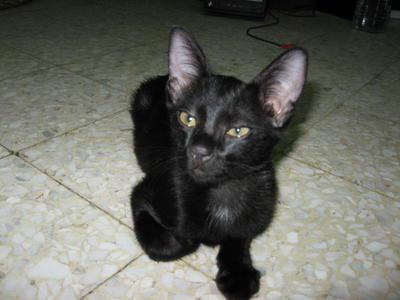

In [52]:
example_image = example_row['Images']

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)


## Uczenie - typy zmiennych, hiperparametry i modele

In [53]:
train_data = train_data.sample(500, random_state=0)


autogluon automatycznie rozpoznaje typy zmiennych

In [59]:
from autogluon.tabular import FeatureMetadata
feature_metadata = FeatureMetadata.from_df(train_data)

print(feature_metadata)

('float', [])        :  1 | ['PhotoAmt']
('int', [])          : 19 | ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', ...]
('object', [])       :  4 | ['Name', 'RescuerID', 'PetID', 'Images']
('object', ['text']) :  1 | ['Description']


i ma przygotowany zestaw domyślnych hiperparametrów dla danych multimodalnych.

In [60]:
from autogluon.tabular.configs.hyperparameter_configs import get_hyperparameter_config
hyperparameters = get_hyperparameter_config('multimodal')

hyperparameters


{'NN': {},
 'GBM': [{},
  {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
  'GBMLarge'],
 'CAT': {},
 'XGB': {},
 'AG_TEXT_NN': ['medium_quality_faster_train'],
 'AG_IMAGE_NN': {}}

Aby rozpocząć uczenie sieci, wystarczy tylko podać kilka argumentów...

In [61]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label=label).fit( # label to AdoptionSpeed - zmienna celu
    train_data=train_data,                     # train data to wysamplowane zmienne na podstawie ktorych predykujemy
    hyperparameters=hyperparameters,           # hiperparametry modeli - tu, domyslne dla multimodala
    feature_metadata=feature_metadata,         # metadata (typy zmiennych), okresla ktory model przylozymy do ktorych zmiennych
    time_limit=900,                            # mozemy okreslic ile czasu chcemy dac 
)

/home/kurowskik/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kurowskik/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kurowskik/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argu


... aby utworzyć wiele modeli, które możemy następnie zaledwie jedną komendą porównać na zbiorze testowym (nie tylko pod względem wyniku, ale też n.in. tempa jego osiągniecia, czy tempie uczenia)


In [57]:
leaderboard = predictor.leaderboard(test_data)


                 model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           LightGBMXT    0.328776       0.37        0.044802       0.011404   1.509037                 0.044802                0.011404           1.509037            1       True          2
1  WeightedEnsemble_L2    0.328776       0.37        0.046339       0.011863   1.731998                 0.001537                0.000459           0.222961            2       True          7
2        LightGBMLarge    0.323775       0.37        0.035372       0.007688  11.759903                 0.035372                0.007688          11.759903            1       True          6
3       NeuralNetMXNet    0.297099       0.33        0.456137       0.207687   3.394728                 0.456137                0.207687           3.394728            1       True          5
4              XGBoost    0.292431       0.35

Finalnie możemy porównać rezultaty otrzymanych modeli 